### Tree of Thoughts

> **Note:**
> The code used in this notebook is adapted from the official LangGraph tutorial:
> [https://langchain-ai.github.io/langgraph/tutorials/tot/tot/](https://langchain-ai.github.io/langgraph/tutorials/tot/tot/)
>
> It demonstrates an application of the **Tree of Thoughts** concept, originally introduced in the following research paper:
> [Tree of Thoughts: Deliberate Problem Solving with Large Language Models (arXiv:2305.10601)](https://arxiv.org/abs/2305.10601)


In [1]:
# import os, getpass
# def _set_env(var: str):
#     if not os.environ.get(var):
#         os.environ[var] = getpass.getpass(f"{var}: ")
#
# _set_env("OPENAI_API_KEY")

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

## Task Definition

Our agent will try to play the **"Game of 24"**. Given 4 numbers, it must generate a math equation that uses each of these numbers exactly one time to evaluate to a value of 24.


In [3]:
import operator
from typing import List, Literal, Union, NamedTuple, Optional
from pydantic import BaseModel, Field

OperatorType = Literal["+", "-", "*", "/"]
TokenType = Union[float, OperatorType]

## We use these schemas to prompt the LLM to generate equations that evaluate to 24.


class Equation(BaseModel):
    """The formula combining the provided numbers to reach the target of 24."""

    tokens: List[TokenType] = Field(
        description="The stack of tokens and operators in reverse-polish notation. Example: [3, 4, '+', -1, '*'] would evaluate to (3 + 4) * -1 = -7.",
    )

    def compute(self) -> float:
        op_funcs = {
            "+": operator.add,
            "-": operator.sub,
            "*": operator.mul,
            "/": operator.truediv,
        }
        stack = []
        for token in self.tokens:
            if isinstance(token, float):
                stack.append(token)
            else:
                b, a = stack.pop(), stack.pop()
                stack.append(op_funcs[token](a, b))

        return stack[0]


class GuessEquations(BaseModel):
    """Submit multiple equations as guesses."""

    reasoning: str = Field(
        description="The reasoning behind the submitted guesses. Explain how you arrived at these equations."
    )

    equations: List[Equation] = Field(
        description="The list of equations to submit as guesses."
    )


## These objects will represent a single "candidate" (or scored candidate) within our agent's state.
# You can update the candidate object to match your own task.


class Candidate(NamedTuple):
    candidate: Equation
    score: Optional[float] = None
    feedback: Optional[str] = None

    def __str__(self):
        try:
            computed = self.candidate.compute()
        except Exception as e:
            computed = f"Invalid equation: {self.candidate.tokens}; Error: {repr(e)}"

        return f"Equation({self.candidate.tokens}) = {computed} (Reward: {self.score})"


class ScoredCandidate(Candidate):
    candidate: Equation
    score: float
    feedback: str

## Fetch Data

We'll use an example from the Game of 24 dataset.


In [4]:
import requests
import csv

csv_data = requests.get(
    "https://storage.googleapis.com/benchmarks-artifacts/game-of-24/24.csv"
).content.decode("utf-8")
# Get just the Puzzles column (column index 1)
puzzles = [row[1].strip() for row in csv.reader(csv_data.splitlines()[1:])]

print(f"Example puzzles: {puzzles[:3]}")

Example puzzles: ['1 1 4 6', '1 1 11 11', '1 1 3 8']


## Expander

The "tree of thoughts" algorithm is relatively generic. The primary two task-specific components are the **expander** and the **scorer**. The **expander** (the augmented LLM) tries to generate 1 or more solutions to the problem. On subsequent attempts, it is given a seed/candidate value from the previous search.

You can update this section to match your own task requirements. The expander can be arbitrarily complex. All that's required is that it accepts the problem and an optional previous attempt (or attempts) and returns a new result.


In [5]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are playing the Game of 24. Using the provide numbers, create an equation that evaluates to 24.\n"
            "Submit exactly {k} guesses for this round.",
        ),
        ("user", "Solve the 24 game for these numbers: {problem}.{candidate}"),
    ],
).partial(candidate="")
llm = ChatOpenAI(model="gpt-4o-mini")

bound_llm = llm.with_structured_output(GuessEquations)
solver = prompt | bound_llm

## Scorer

In this game, the scorer is easy. We need to assert two things:

1. The LLM has generated a valid equation using each number exactly one time.
2. The equation evaluates to 24.

You can update this function to match your own task requirements.


In [6]:
def compute_score(problem: str, candidate: Candidate) -> ScoredCandidate:
    numbers = list(map(int, problem.split()))
    # Check that the candidate equation uses all 4 numbers exactly once
    used_numbers = [
        token for token in candidate.candidate.tokens if isinstance(token, float)
    ]
    if sorted(used_numbers) != sorted(numbers):
        score = 0
        feedback = "The equation must use all 4 numbers exactly once."
        return ScoredCandidate(
            candidate=candidate.candidate, score=score, feedback=feedback
        )
    try:
        result = candidate.candidate.compute()
        score = 1 / (1 + abs(24 - result))
        feedback = f"Result: {result}"
    except Exception as e:
        score = 0
        feedback = f"Invalid equation. Error: {repr(e)}"
    return ScoredCandidate(
        candidate=candidate.candidate, score=score, feedback=feedback
    )

## Graph
it's time to create our graph.

In [7]:
import operator
from typing import Optional, Dict, Any
from typing_extensions import Annotated, TypedDict
from langgraph.graph import StateGraph

from langchain_core.runnables import RunnableConfig
from langgraph.constants import Send
from langgraph.checkpoint.memory import MemorySaver


def update_candidates(
    existing: Optional[list] = None,
    updates: Optional[Union[list, Literal["clear"]]] = None,
) -> List[str]:
    if existing is None:
        existing = []
    if updates is None:
        return existing
    if updates == "clear":
        return []
    # Concatenate the lists
    return existing + updates


class ToTState(TypedDict):
    problem: str
    candidates: Annotated[List[Candidate], update_candidates]
    scored_candidates: Annotated[List[ScoredCandidate], update_candidates]
    depth: Annotated[int, operator.add]


class Configuration(TypedDict, total=False):
    max_depth: int
    threshold: float
    k: int
    beam_size: int


def _ensure_configurable(config: RunnableConfig) -> Configuration:
    """Get params that configure the search algorithm."""
    configurable = config.get("configurable", {})
    return {
        **configurable,
        "max_depth": configurable.get("max_depth", 10),
        "threshold": config.get("threshold", 0.9),
        "k": configurable.get("k", 5),
        "beam_size": configurable.get("beam_size", 3),
    }


class ExpansionState(ToTState):
    seed: Optional[Candidate]


def expand(state: ExpansionState, *, config: RunnableConfig) -> Dict[str, List[str]]:
    """Generate the next state."""
    configurable = _ensure_configurable(config)
    if not state.get("seed"):
        candidate_str = ""

    else:
        candidate_str = "\n\n" + str(state["seed"])

    try:
        equation_submission = solver.invoke(
            {
                "problem": state["problem"],
                "candidate": candidate_str,
                "k": configurable["k"],
            },
            config=config,
        )
    except Exception:
        return {"candidates": []}
    new_candidates = [
        Candidate(candidate=equation) for equation in equation_submission.equations
    ]
    return {"candidates": new_candidates}


def score(state: ToTState) -> Dict[str, List[float]]:
    """Evaluate the candidate generations."""
    candidates = state["candidates"]
    scored = []
    for candidate in candidates:
        scored.append(compute_score(state["problem"], candidate))
    return {"scored_candidates": scored, "candidates": "clear"}


def prune(
    state: ToTState, *, config: RunnableConfig
) -> Dict[str, List[Dict[str, Any]]]:
    scored_candidates = state["scored_candidates"]
    beam_size = _ensure_configurable(config)["beam_size"]
    organized = sorted(
        scored_candidates, key=lambda candidate: candidate[1], reverse=True
    )
    pruned = organized[:beam_size]
    return {
        # Update the starting point for the next iteration
        "candidates": pruned,
        # Clear the old memory
        "scored_candidates": "clear",
        # Increment the depth by 1
        "depth": 1,
    }


def should_terminate(
    state: ToTState, config: RunnableConfig
) -> Union[Literal["__end__"], Send]:
    configurable = _ensure_configurable(config)
    solved = state["candidates"][0].score >= configurable["threshold"]
    if solved or state["depth"] >= configurable["max_depth"]:
        return "__end__"
    return [
        Send("expand", {**state, "somevalseed": candidate})
        for candidate in state["candidates"]
    ]


# Create the graph
builder = StateGraph(state_schema=ToTState, config_schema=Configuration)

# Add nodes
builder.add_node(expand)
builder.add_node(score)
builder.add_node(prune)

# Add edges
builder.add_edge("expand", "score")
builder.add_edge("score", "prune")
builder.add_conditional_edges("prune", should_terminate, path_map=["expand", "__end__"])

# Set entry point
builder.add_edge("__start__", "expand")

# Compile the graph
graph = builder.compile(checkpointer=MemorySaver())

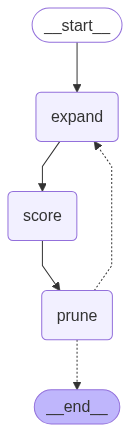

In [8]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Run
Now let's try it on one of the puzzles!

In [16]:
config = {
    "configurable": {
        "thread_id": "test_1",
        "depth": 10,
    }
}
for step in graph.stream({"problem": puzzles[42]}, config):
    print(step)

{'expand': {'candidates': [Candidate(candidate=Equation(tokens=[12.0, 7.0, '*', 5.0, '-', 1.0, '+']), score=None, feedback=None), Candidate(candidate=Equation(tokens=[12.0, 5.0, '*', 7.0, '-', 1.0, '+']), score=None, feedback=None), Candidate(candidate=Equation(tokens=[5.0, 7.0, '*', 1.0, '+', 12.0, '-']), score=None, feedback=None), Candidate(candidate=Equation(tokens=[12.0, 1.0, '-', 5.0, '*', 7.0, '+']), score=None, feedback=None), Candidate(candidate=Equation(tokens=[7.0, 5.0, '*', 1.0, '+', 12.0, '-']), score=None, feedback=None)]}}
{'score': {'scored_candidates': [ScoredCandidate(candidate=Equation(tokens=[7.0, 5.0, '+', 12.0, '+', 1.0, '-']), score=0.5, feedback='Result: 23.0'), ScoredCandidate(candidate=Equation(tokens=[12.0, 1.0, '/', 7.0, '+', 5.0]), score=0.16666666666666666, feedback='Result: 19.0'), ScoredCandidate(candidate=Equation(tokens=[1.0, 12.0, '*', 5.0, '-', 7.0, '+']), score=0.09090909090909091, feedback='Result: 14.0'), ScoredCandidate(candidate=Equation(tokens=

In [17]:
final_state = graph.get_state(config)
winning_solution = final_state.values["candidates"][0]
search_depth = final_state.values["depth"]
if winning_solution[1] == 1:
    print(f"Found a winning solution in {search_depth} steps: {winning_solution}")
else:
    print(
        f"Failed to find a winning solution in {search_depth} steps. Best guess: {winning_solution}"
    )

Found a winning solution in 11 steps: Equation([5.0, 7.0, '*', 1.0, '+', 12.0, '-']) = 24.0 (Reward: 1.0)


## Evaluation
Now let's create an evaluation function

In [18]:
from typing import List, Dict, Any
import statistics

def evaluate_tot_llm_performance(results: List[Dict[str, Any]]) -> Dict[str, Any]:
    """
    Evaluate LLM performance in Tree of Thoughts runs.

    Parameters:
        results: A list of dictionaries, each representing the final state from a ToT run.
            Each dict should contain:
                - "solved": bool
                - "depth": int
                - "best_score": float
                - "equation": Equation object or string

    Returns:
        A summary dictionary with aggregate statistics.
    """
    num_trials = len(results)
    num_solved = sum(1 for r in results if r["solved"])
    avg_depth = statistics.mean(r["depth"] for r in results)
    avg_score = statistics.mean(r["best_score"] for r in results)
    max_score = max(r["best_score"] for r in results)

    solved_equations = [r["equation"] for r in results if r["solved"]]

    return {
        "total_problems": num_trials,
        "solved_problems": num_solved,
        "accuracy": num_solved / num_trials,
        "average_depth": round(avg_depth, 2),
        "average_best_score": round(avg_score, 3),
        "highest_score": round(max_score, 3),
        "solved_equations": solved_equations,
    }

## Gather results from multiple runs
Now let's run the ToT on many problem and extract results

In [19]:
def run_tot_on_problem(problem: str, graph, config) -> Dict[str, Any]:
    """
    Run Tree of Thoughts on a single Game of 24 problem and extract evaluation-relevant metrics.

    Parameters:
        problem: A string like "3 4 6 1"
        graph: Compiled LangGraph object
        config: Dict passed to LangGraph nodes

    Returns:
        A dictionary compatible with evaluation function:
        {
            "solved": bool,
            "depth": int,
            "best_score": float,
            "equation": str
        }
    """
    state_input = {"problem": problem}

    # Run the graph (stream can be skipped if not needed)
    for _ in graph.stream(state_input, config):
        pass  # progress through the full search

    # Get final state
    final_state = graph.get_state(config).values
    depth = final_state["depth"]
    candidates = final_state["candidates"]

    # Select best-scoring candidate
    best = max(candidates, key=lambda c: c.score)

    return {
        "solved": best.score >= config["configurable"].get("threshold", 0.9),
        "depth": depth,
        "best_score": best.score,
        "equation": str(best.candidate.tokens),
        "feedback": best.feedback
    }


def run_tot_on_many_problems(puzzles: List[str], graph, limit: int = 10) -> List[Dict[str, Any]]:
    config = {
        "configurable": {
            "thread_id": "eval_batch",
            "depth": 10,
            "threshold": 0.99,  # stricter match for Game of 24
            "k": 5,
            "beam_size": 3,
        }
    }

    results = []
    for i, puzzle in enumerate(puzzles[:limit]):
        print(f"Running puzzle {i + 1}: {puzzle}")
        try:
            result = run_tot_on_problem(puzzle, graph, config)
            results.append(result)
        except Exception as e:
            print(f"Error on puzzle {i + 1}: {repr(e)}")
            results.append({
                "solved": False,
                "depth": -1,
                "best_score": 0,
                "equation": "ERROR",
                "feedback": str(e),
            })
    return results

results = run_tot_on_many_problems(puzzles=puzzles[1:101], graph = graph, limit = 150)


Running puzzle 1: 1 1 11 11
Error on puzzle 1: GraphRecursionError('Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT')
Running puzzle 2: 1 1 3 8
Running puzzle 3: 1 1 1 8
Running puzzle 4: 6 6 6 6
Running puzzle 5: 1 1 2 12
Running puzzle 6: 1 2 2 6
Running puzzle 7: 1 1 10 12
Running puzzle 8: 2 2 10 10
Running puzzle 9: 1 1 1 12
Running puzzle 10: 1 1 2 8
Running puzzle 11: 1 1 4 8
Running puzzle 12: 1 1 5 8
Running puzzle 13: 4 6 11 11
Running puzzle 14: 1 1 3 12
Running puzzle 15: 2 2 2 12
Running puzzle 16: 1 1 4 12
Running puzzle 17: 1 1 12 12
Running puzzle 18: 3 3 3 8
Running puzzle 19: 1 1 2 6
Running puzzle 20: 1 1 2 11
Running puzzle 21: 1 2 3 4
Running puzzle 22: 11 11 12 12
Running puzzle 23: 3 7 7 8
Running puzzle 24: 1 1 13 13
Running puzzle 25: 1 2 4 12
Running puzzle 26: 1 1 3 

## Evaluate Performance
Now let's Evaluate the Performance

In [20]:
def evaluate_tot_llm_performance(results: List[Dict[str, Any]]) -> Dict[str, Any]:
    num_trials = len(results)
    num_solved = sum(1 for r in results if r["solved"])
    avg_depth = sum(r["depth"] for r in results if r["depth"] >= 0) / max(1, num_trials)
    avg_score = sum(r["best_score"] for r in results) / max(1, num_trials)
    max_score = max(r["best_score"] for r in results)

    return {
        "total_problems": num_trials,
        "solved_problems": num_solved,
        "accuracy": round(num_solved / num_trials, 3),
        "average_depth": round(avg_depth, 2),
        "average_best_score": round(avg_score, 3),
        "highest_score": round(max_score, 3),
        # "example_solutions": [r["equation"] for r in results if r["solved"]][:3]
        "example_solutions": [r["equation"] for r in results if r["solved"]]
    }


metrics = evaluate_tot_llm_performance(results=results)